# Objective

- Run SMDL on patch based data

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
import numpy as np
import torch
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl
import hydra
import seaborn as sns
import pickle

from omegaconf import DictConfig, OmegaConf
from tqdm import tqdm, trange
from src.utils import soft_threshold, power_method_svd
from src.datasets import get_mnist_dataset
from pathlib import Path
from pprint import pprint

In [3]:
sns.set_theme()
sns.set_context("paper", font_scale=1.0, rc={"text.usetex":True})
sns.set_palette("colorblind")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

In [4]:
from scipy.io import loadmat
data_file = Path.cwd().parents[1] / 'data' / 'IMAGES.mat'
data = loadmat(data_file)

In [5]:
images = data['IMAGES'].transpose((2, 0, 1))
images = images.astype(np.float32)
images.shape

(10, 512, 512)

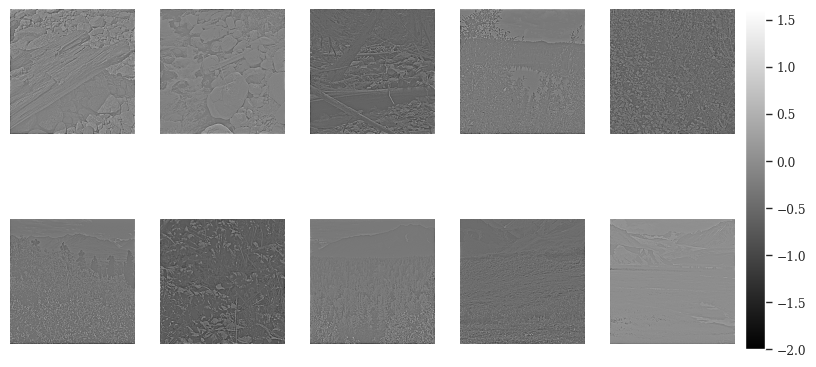

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    # print(i)
    im = ax.imshow(images[i], cmap='gray')
    ax.axis('off')
    
# Add colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.68])
fig.colorbar(im, cax=cbar_ax)

# plt.tight_layout()
plt.show()


**Extract patches from natural scenes**

In [7]:
from sklearn.feature_extraction.image import extract_patches_2d

In [8]:
# Train an online dictionary learning algorithm using patches from the images
patch_size = 16
# for _ in range(len(images)):
patches = []
for img in images:
    patch_data = extract_patches_2d(img, (patch_size, patch_size), max_patches=5000, random_state=42)
    patch_data = patch_data.reshape(patch_data.shape[0], -1)
    patches.append(patch_data)
    
patches = np.concatenate(patches, axis=0)
patches = patches.astype(np.float32)
patches.shape

(50000, 256)

**Normalize patches to have zero mean and unit variance**

In [9]:
# Normalize the patches
patches -= patches.mean(axis=0, keepdims=True)
patches /= patches.std(axis=0, keepdims=True)


**Create a pytorch dataset and dataloader for batchwise training**

In [10]:
# create dataset and dataloader
from torch.utils.data import Dataset, DataLoader
batch_size = 128
patch_dataset = torch.from_numpy(patches).float()
patch_dataloader = DataLoader(patch_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [11]:
def reconstruct_patches(dico, patches):
    """Reconstruct the patches from the dictionary"""
    return np.dot(dico.transform(patches), dico.components_)

def compute_reconstruction_error(dico, patches):
    """Compute the reconstruction error"""
    return np.sum((patches - reconstruct_patches(dico, patches)) ** 2) / len(patches)

**Batchwise Dictionary Learning (K Means initialization)**

In [12]:
# Compute Kmeans on the dataset
from sklearn.cluster import KMeans
n_atoms = 192
kmeans = KMeans(n_clusters=n_atoms, random_state=42, max_iter=1000)
kmeans.fit(patches)


/n/home13/shubham/.conda/envs/representations/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=1000, n_clusters=192, random_state=42)

In [14]:
from sklearn.decomposition import SparseCoder
centres = kmeans.cluster_centers_
centres /= np.linalg.norm(centres, axis=1, keepdims=True)
coder = SparseCoder(dictionary=centres, transform_algorithm='lasso_lars', transform_alpha=0.14)
coder.fit(patches)

SparseCoder(dictionary=array([[-0.00289905, -0.00795327, -0.01948691, ..., -0.03739953,
        -0.02628019, -0.03479756],
       [-0.04389457, -0.05195476, -0.05549538, ..., -0.07187948,
        -0.07446829, -0.06591816],
       [-0.05023185, -0.04868454, -0.05192042, ...,  0.01280858,
        -0.00026869, -0.01977644],
       ...,
       [ 0.04150675,  0.05275858, -0.02008267, ..., -0.01252397,
        -0.01630101, -0.00349653],
       [ 0.02550174,  0.0282482 ,  0.03584935, ..., -0.00021778,
        -0.01382288, -0.0276694 ],
       [-0.00529628,  0.00330295, -0.00482458, ...,  0.04733905,
        -0.02170671, -0.03201818]], dtype=float32),
            transform_algorithm='lasso_lars', transform_alpha=0.14)

In [15]:
init_codes=coder.transform(patches)

/n/home13/shubham/.conda/envs/representations/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 83 iterations, alpha=1.374e-03, previous alpha=1.374e-03, with an active set of 62 regressors.
  warnings.warn(
/n/home13/shubham/.conda/envs/representations/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 134 iterations, alpha=7.677e-04, previous alpha=7.677e-04, with an active set of 87 regressors.
  warnings.warn(
/n/home13/shubham/.conda/envs/representations/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 114 iteration

In [22]:
Path.cwd().parents[1]

PosixPath('/n/home13/shubham/Current Projects/bioplausible_learning/code')

In [23]:
result_folder = Path.cwd().parents[1] / "models" / "patches"
os.makedirs(result_folder, exist_ok=True)
with open(result_folder / "patches_kmeans_192.pkl", 'wb') as f:
    save_data = {'data': patches, 'dict': centres, 'codes': init_codes}
    pickle.dump(save_data, f)

In [14]:
from sklearn.decomposition import MiniBatchDictionaryLearning

In [16]:
dico_init = kmeans.cluster_centers_ # 192 x 256
# dico_init = dico_init / np.linalg.norm(dico_init, axis=1, keepdims=True)
dico_means = MiniBatchDictionaryLearning(n_atoms, alpha=1, n_iter=1, batch_size=batch_size, dict_init=dico_init)
num_epochs = 10
n_updates = 0
reconst_error = []
for epoch in trange(num_epochs):
    for batch in patch_dataloader:
        dico_means.partial_fit(batch)
        n_updates += 1
        if n_updates % 100 == 0:
            reconst_error.append(compute_reconstruction_error(dico_means, patches))
            # print(f"Reconstruction error: {reconst_error[-1]}")

100%|██████████| 10/10 [47:21<00:00, 284.14s/it]


In [17]:
D_means = kmeans.cluster_centers_.T
print(D_means.shape)

(256, 192)


In [19]:
from sklearn.decomposition import SparseCoder
coder = SparseCoder(dictionary=D_means.T, transform_alpha=1.0)
mean_latents = coder.fit_transform(patches)


/n/home13/shubham/.conda/envs/representations/lib/python3.10/site-packages/sklearn/decomposition/_dict_learning.py:193: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


In [20]:
mean_latents.shape

(50000, 192)

In [21]:
import pickle
patch_dict_file = Path.cwd().parents[1] / 'init_data' / 'patch_dict_kmeans_data_tmp.pkl'
with open(patch_dict_file, 'wb') as f:
    save_data = {'dico': dico_means, 'patches': patches, 'latent': mean_latents}
    pickle.dump(save_data, f)

In [ ]:
mse_error_means = np.array(reconst_error)
plt.plot(mse_error_means)
plt.xlabel("Number of updates x 100")
plt.ylabel("Mean Squared Error")

In [5]:
# Let's read this back in and see if it works
import pickle
patch_dict_file = Path.cwd().parents[1] / 'init_data' / 'patch_dict_kmeans_data_tmp.pkl'
with open(patch_dict_file, 'rb') as f:
    load_data = pickle.load(f)
print(load_data.keys())

dict_keys(['dico', 'patches', 'latent'])


In [17]:
load_data['kmeans'] = kmeans
print(load_data.keys())

dict_keys(['dico', 'patches', 'latent', 'kmeans'])


In [19]:
kmeans.cluster_centers_.shape

(192, 256)

In [18]:
with open(patch_dict_file, 'wb') as f:
    pickle.dump(load_data, f)

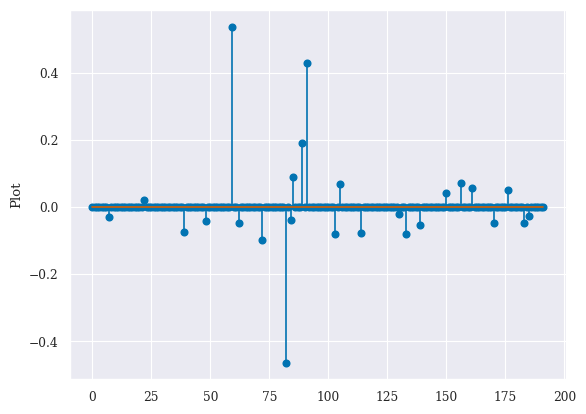

In [8]:
fig, ax = plt.subplots()
ax.stem(load_data['latent'][0])
ax.set_ylabel('Plot')
fig.show()


The plot for latents show that latents are not one hot, so we can use these latents for our intialization of the dictionary learning algorithm.

**Batchwise Dictionary Learning (Alt min)**

In [ ]:
# Train dictionary
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
dico = MiniBatchDictionaryLearning(n_components=192, alpha=1, n_iter=1, batch_size=batch_size)
num_epochs = 10
n_updates = 0

reconst_error = []
for epoch in trange(num_epochs):
    for batch in patch_dataloader:
        dico.partial_fit(batch)
        n_updates += 1
        if n_updates % 100 == 0:
            reconst_error.append(compute_reconstruction_error(dico, patches))

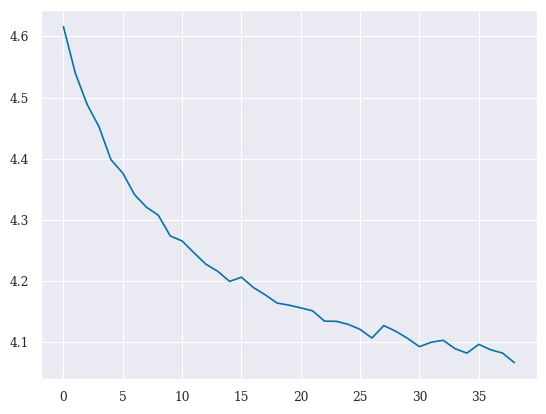

In [18]:
mse_error = np.array(reconst_error)
plt.plot(mse_error)

In [15]:
# Save patch dictionary and patch data
import pickle
patch_dict_file = Path.cwd().parents[1] / 'init_data' / 'patch_dict_data.pkl'
with open(patch_dict_file, 'wb') as f:
    save_data = {'dico': dico, 'patches': patches}
    pickle.dump(dico, f)

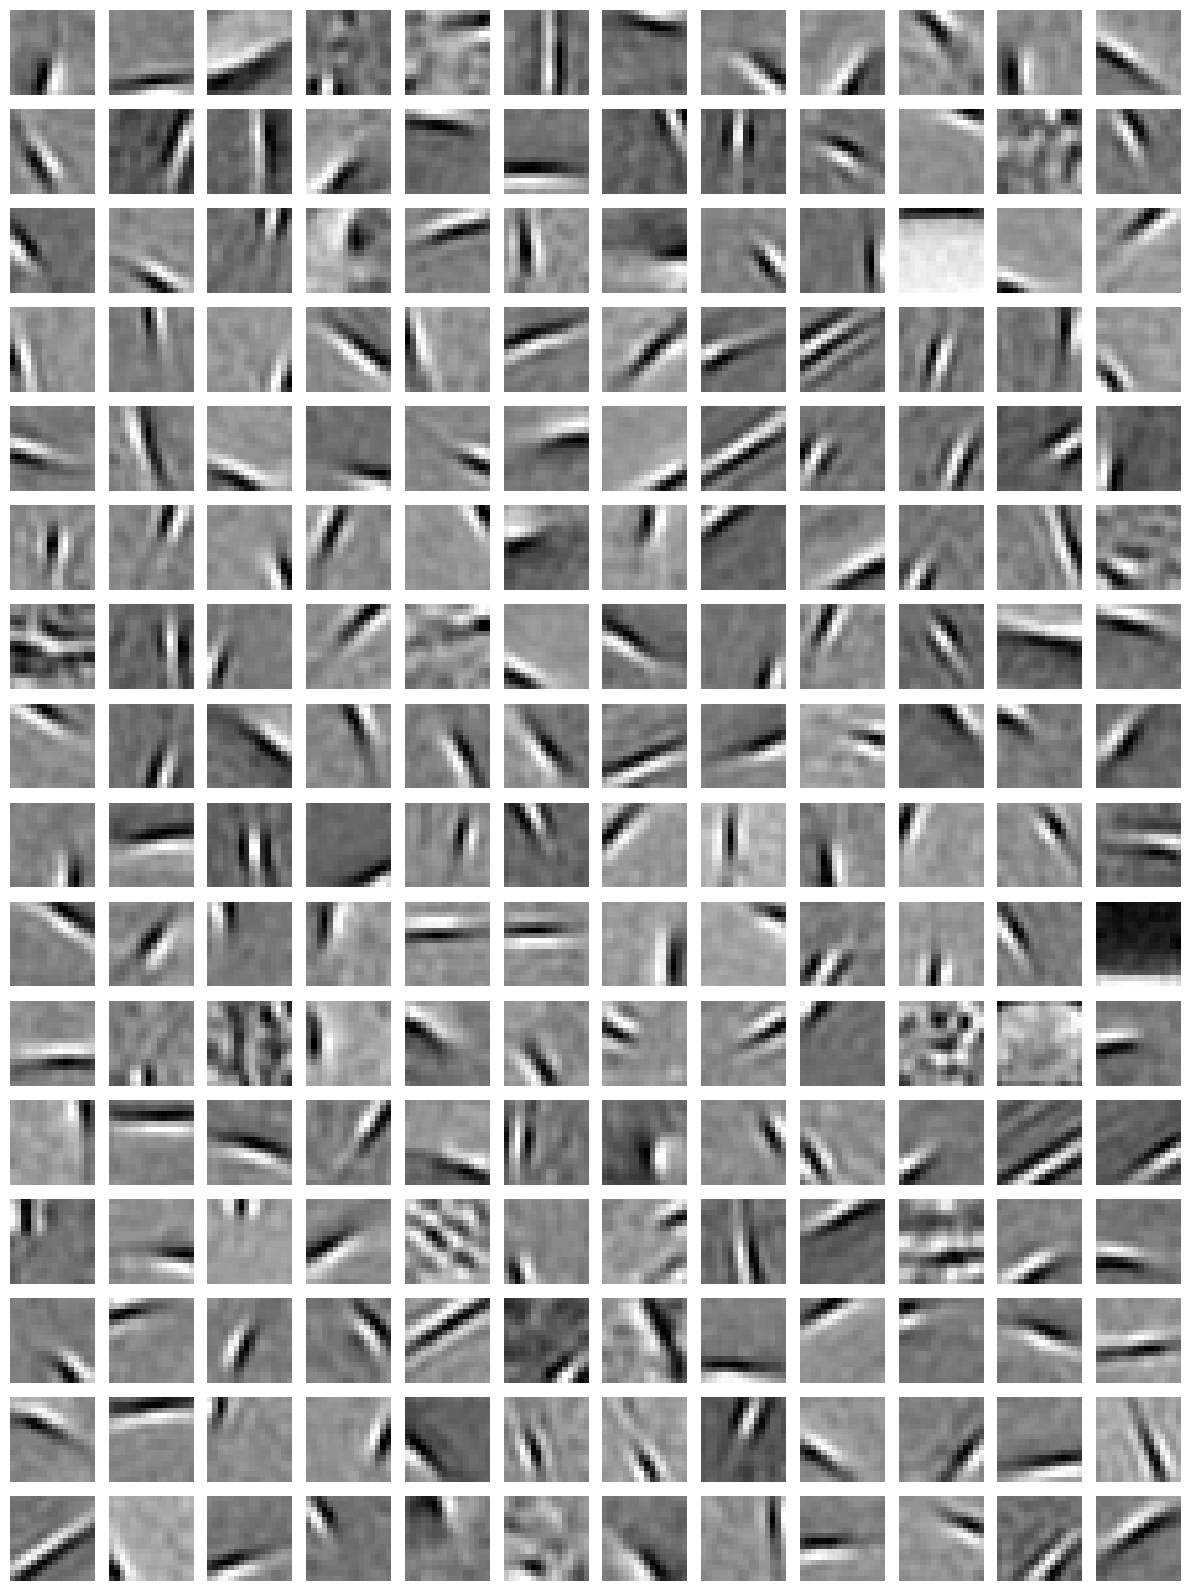

In [16]:
# Visualize the dictionary
dico.components_.shape
fig, axes = plt.subplots(16, 12, figsize=(12, 16))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(dico.components_[i].reshape(patch_size, patch_size), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
# load the saved dictionary
import pickle
patch_dict_file = Path.cwd().parents[1] / 'init_data' / 'patch_dict_data.pkl'
with open(patch_dict_file, 'rb') as f:
    dico = pickle.load(f)

In [20]:
patches.shape

(50000, 256)

In [21]:
# Get the codes for the patches
codes = dico.transform(patches)

In [22]:
# Store code and dict learning object
save_filename = Path.cwd().parents[1] / 'init_data' / 'patch_dict_codes.pkl'
with open(save_filename, 'wb') as f:
    save_data = {'codes': codes, 'dico': dico}
    pickle.dump(save_data, f)

In [23]:
### Add noise to the dictionary atooms

D_est = dico.components_.T
print(D_est.shape)

(256, 192)


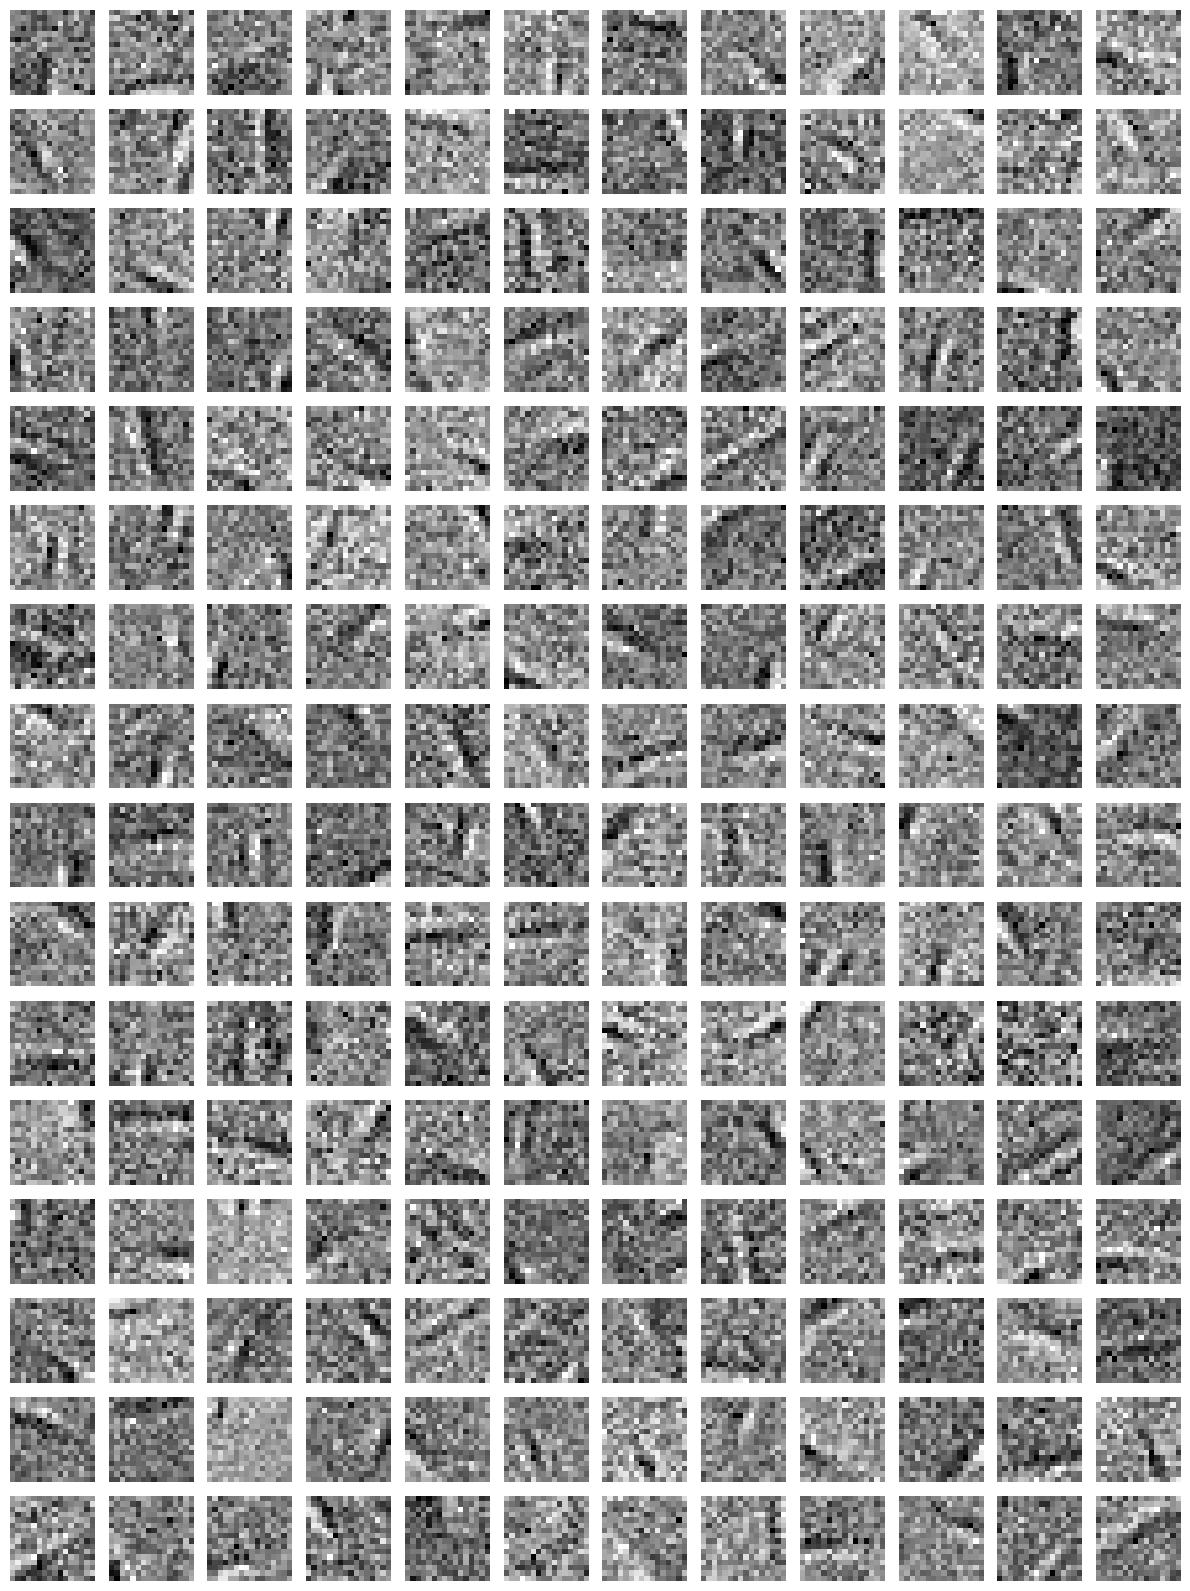

In [24]:
perturbation = 0.1
np.random.seed(42)
D_noisy = D_est + perturbation * np.random.randn(*D_est.shape)
fig, axes = plt.subplots(16, 12, figsize=(12, 16))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(D_noisy[:,i].reshape(patch_size, patch_size), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [31]:
K = D_est.shape[1]

In [26]:
from sklearn.decomposition import SparseCoder
coder = SparseCoder(dictionary=D_noisy.T, transform_alpha=1.0)
noisy_latents = coder.fit_transform(patches)


In [32]:
save_path = Path.cwd().parents[1] /'init_data'
save_file = save_path / f'patch_dict_noisy_codes_{perturbation}_lam{1.0}_K{K}.pkl'
with open(save_file, 'wb') as f:
    save_data = {'noisy_latent': noisy_latents, 'Noisy_Dictionary': D_noisy, 'Dictionary': D_est, 'latent': codes, 'obj': dico}
    pickle.dump(save_data, f)


**Baseline $R^2$ value**

In [17]:
import pickle

In [18]:
perturbation = 0.1
K = 192
load_path = Path.cwd().parents[1] / 'init_data'
load_file = load_path / f'patch_dict_noisy_codes_{perturbation}_lam{1.0}_K{K}.pkl'
with open(load_file, 'rb') as f:
    load_data = pickle.load(f)

In [23]:
dico = load_data['obj']
codes = load_data['latent']
Dest = load_data['Dictionary']
print(Dest.shape, codes.shape)

(256, 192) (50000, 192)


In [30]:
predictions = codes @ Dest.T

In [29]:
from sklearn import metrics

In [34]:
r2 = metrics.r2_score(patches, predictions)
print("The baseline R2 score is: {:.3f}".format(r2))

The baseline R2 score is: 0.379
